# Lat - Depth Plots

This notebook makes the Lat-Depth plots (both for the main MS and the error analysis for the supplemental information).

In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
#!pip install regionmask

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
from scipy.optimize import lsq_linear
from typing import Iterable
from scipy import stats
import pyproj as proj
import scipy.interpolate as interpolate
import scipy.integrate as integrate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.font_manager
#font = {'family': 'serif', 'serif': ['Palatino'], 'size': 14}
#plt.rc('font', **font)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=False)
#plt.rc('text', usetex=False)

### Load the Data

In [ ]:
# Pick which variable to use for all calculations
delv = 'delta_T_merged' # ARGO era
wodperiod='A5B7'

delv = 'delta_T_merged_5564' # 1955-1964 climatology
wodperiod='5564'

cutlat = -50 # most Southern Latitude to include

# LOAD THE DATA
import sys
sys.path.insert(0,'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/src')
from importlib import reload
import loadPickle as loadPickle
reload(loadPickle)
cruises_dset = loadPickle.loadPickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl', cutlat)
cruises_dset 

<xarray.Dataset>
Dimensions:                    (index: 534)
Coordinates:
  * index                      (index) int64 10 11 12 13 14 ... 615 616 617 618
Data variables: (12/40)
    Station                    (index) object '40' '40' '40' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-08 ... 1906-08-14
    Lat degrees                (index) float64 -39.0 -39.0 -39.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -9.5 -9.5 -9.5 ... -18.0 -18.0
    Lon degrees                (index) float64 20.0 20.0 20.0 ... 112.0 112.0
    Lon minutes                (index) float64 56.0 56.0 56.0 ... 9.0 9.0 9.0
    ...                         ...
    delta_T_seasonal_5564      (index) float64 -1.05 -1.454 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 18.15 16.85 15.55 ... 8.873 1.416
    delta_T_merged             (index) float64 -0.6061 -0.3704 ... -0.3018
    WOA_temp                   (index) float64 18.59 17.93 16.96 ... 8.995 1.398
    delta_T_merged_5564        (index) float64 -1.832 -1.609 ... -0.8942 -0.2845
    WOA_temp_5564              (index) float64 17.37 16.69 15.22 ... 8.706 1.416

In [ ]:
# LOAD WOA for plotting contours

# Average over a zonal slice
lons = slice(40, 100)

url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/1.00/woa18_A5B7_t00_01.nc' # ARGO
#url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/A5B7/0.25/woa18_A5B7_t00_04.nc' # ARGO
WOA_JFM = xr.open_dataset(url, decode_times=False)
WOA_TEMPS = WOA_JFM.sel(lon=lons).mean('lon').t_an.squeeze()


## Bin the data

In [ ]:
# Define a function to do the binning
# Inputs: 
#         ds_out   -   xarray dataset 
#         delv        -   string naming the variable to bin (default to 'delta_T_merged')
#         lats_bin    -   array of the new depths to grid to 
#         depths      -   array of the new depths to grid to
# Returns:
#         temps       -   means in each bin
#         counts      -   number of obs in each bin
#         pvals       -   P-Val (from t-test) in each bin
#         latf        -   flattened array of new lats
#         depthf      -   flattened array of new depths
def zonal_depth_bin(dsout, delv, lats_bin, depths):
  lattol = np.mean(np.abs(np.diff(lats_bin)))/2
  print(f'Latitude bin size: {lattol}')
  depthtol = np.mean(np.diff(depths))/2
  print(f'Depth bin size: {depthtol}')
  LAT, DEPTH = np.meshgrid(lats_bin, depths)
  #LATE, DEPTHE = np.meshgrid(late_bin, depths)
  latf = np.ravel(LAT) #flattened lats
  depthf = np.ravel(DEPTH) #flattened depths

  # Pre-allocate some arrays
  temps = np.nan*np.zeros((latf.shape))
  counts = np.zeros((latf.shape))
  pvals = np.nan*np.zeros((latf.shape))
   
  shapiro =  np.nan*np.zeros((latf.shape))

  for i in range(0, len(latf)):
    depthtarget_ind = np.argmin(np.abs(depthf[i] - depths))
    if depthtarget_ind == len(depths)-1: #bin extends to surface
      depthtolup = 10000# use any positive number
    else:
      depthtolup = -(depths[depthtarget_ind+1] - depths[depthtarget_ind])/2
    if depthtarget_ind == 0:
      depthtodn = depthtolup
    else:
      depthtodn = -(depths[depthtarget_ind] - depths[depthtarget_ind-1])/2
  
    tempds = dsout.where( (dsout.lat>=(latf[i]-lattol)) & (dsout.lat<(latf[i]+lattol))).where( (dsout.Depth>=(depthf[i]-depthtolup)) & (dsout.Depth<(depthf[i]+depthtodn)), drop=True)
    binnedt = tempds[delv]
    temps[i] = binnedt.mean()
    counts[i] = binnedt.count()
    woat = tempds['WOA_temp']
    rawt = woat - binnedt

    # One sample T Test
    dummy, pvals[i] = stats.ttest_1samp(binnedt, 0, nan_policy='omit')
    #dummy, pvals[i] = stats.wilcoxon(binnedt)
    #dummy, pvals[i] = stats.mannwhitneyu(rawt, woat)
    #dummy, pvals[i] = stats.ttest_rel(rawt, woat, nan_policy='omit')
    #if binnedt.size>=2:
      #dummy, shapiro[i] = stats.shapiro(binnedt)
  return temps, counts, pvals, latf, depthf

In [ ]:
# Bin the data for the MS plot

temp_dset = cruises_dset.copy()
delv = 'delta_T_merged'
wodperiod='A5B7'
#delv = 'delta_T_merged_5564'
# DEFINE THE BINNING 

### For the manuscript (full resolution) ####
lats_bin = np.arange(cutlat, 10, 5)
depths = np.linspace(4000, 0, 16)
nl = lats_bin.size
nd = depths.size


# IF REMOVING A CRUISE
#######################
#temp_dset = temp_dset.where(temp_dset.cruise != 'Gazelle', drop=True)
#wodperiod = 'NoGazelle'
#######################
temps, counts, pvals,  latf, depthf = zonal_depth_bin(temp_dset, delv, lats_bin, depths)

Latitude bin size: 2.5
Depth bin size: -133.33333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/p

Max: 2.187721104414331, Min: -2.5257317260036776


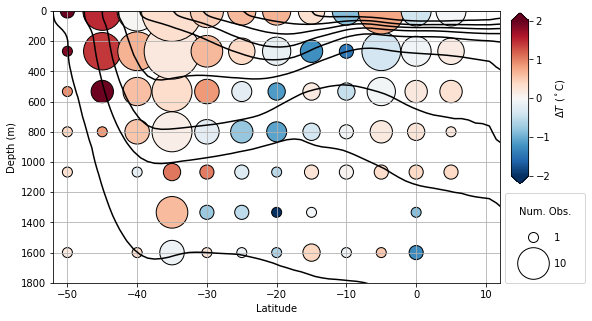

In [ ]:
fig = plt.figure(figsize=(8,5))
countfact = 100
withhatches = False
sc = plt.scatter(latf, depthf, c=temps, vmin=-2, vmax=2, s=counts*countfact, cmap='RdBu_r', edgecolors='k')

print(f'Max: {np.nanmax(temps)}, Min: {np.nanmin(temps)}')


# Make a legend bar
#plt.scatter(-48, 1750, s = 10*100, color='k')
#plt.scatter(-44, 1750, s = 1*100, color='k')
g = lambda s: s/countfact # inverse function to calc. data from size
leg = plt.legend(*sc.legend_elements("sizes", num=[1, 10], func=g, color='w', markeredgecolor='k'), bbox_to_anchor=(1.0, 0.35), handletextpad=1, labelspacing=1.4, borderpad=1.4, title='Num. Obs.')

#mask = ((temps>0) & ((temps - bubble_err[0,:])))
#mask = (np.abs(stds/temps/np.sqrt(counts/1)) > 1) | (counts==1)
#mask = (np.abs(stds/temps/np.sqrt(countstation/1)) > 1) | (counts==1)

#mask = (np.abs(stdstation/temps/np.sqrt(countstation/1)) > 1) | (counts==1)
#mask = (np.abs(stdstation/temps/np.sqrt(dofv+dofg)) > 1) | (counts==1)

#mask = countstation<3
#mask = (np.abs(stds/temps) > 1) | (counts==1)
#mask = (pvals>sortp[pind]) | (counts==1)
#mask = pvals>alpha_fdr
#mask = (np.sign(bubble_err[0,:])*np.sign(temps) < 1) | (np.sign(bubble_err[1,:])*np.sign(temps)<1)

#MASK = mask.reshape(nd, nl)
#plt.scatter(latf[mask], depthf[mask], vmin=-1, vmax=1, s=counts[mask]*100,c='0.0', alpha=0.5)
#plt.contourf(LAT, DEPTH, MASK, 1, hatches=[None,'.'])#, colors='none')
plt.rcParams['hatch.color'] = '0.6'

#if withhatches:
#  plt.contourf(LATE, DEPTHE, np.vstack((False*MASK[:,0], np.vstack((MASK.T, False*MASK[:,-1])))).T, 1, hatches=[None,'..'], colors='none')

plt.ylim(1800, 0)
plt.contour(WOA_TEMPS.lat, WOA_TEMPS.depth, WOA_TEMPS.values, 10,colors='k')
plt.xlim(cutlat-2, 10+2)
plt.grid()
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

#cb = plt.colorbar(extend='both', shrink=0.5, anchor=(1.0,0.5))
cbaxes = fig.add_axes([0.92, 0.4, 0.03, 0.475]) 
cb = plt.colorbar(sc, cax = cbaxes, extend='both') 
cb.set_label('$\Delta T$ ($^\circ$C)')
cb.set_ticks([-2, -1, 0, 1, 2])
#plt.savefig(f'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/Bubbles_3cruise_'+ wodperiod + '.pdf', bbox_inches='tight')

## WITH ERROR ESTIMATES

For the supplementary info we bin the data into larger lat-depth bins and estimate statistical significance using the False Discovery Rate (see Wenegrat et al. 2022 doi: 10.1029/2022GL098217 supplementary material).

In [ ]:
# Bin the data to coarse res
temp_dset = cruises_dset.copy()
delv = 'delta_T_merged'
#delv = 'delta_T_merged_5564'
# DEFINE THE BINNING 

#### For Coarse Binning & Stats ###
lbin = 10
clat = cutlat
lats_bin = np.arange(clat, 10, lbin)
depths = np.flipud(np.arange(0,3000, 500))
#depths = np.linspace(4000, 0, 16)
late = np.arange(clat-lbin, 10+lbin, lbin)
LATE, DEPTHE = np.meshgrid(late, depths)
LAT, DEPTH = np.meshgrid(lats_bin, depths)

nl = lats_bin.size
nd = depths.size
temps, counts, pvals, latf, depthf = zonal_depth_bin(temp_dset, delv, lats_bin, depths)

Latitude bin size: 5.0
Depth bin size: -250.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Warning: converting a masked element to nan.


0.05461975414021698


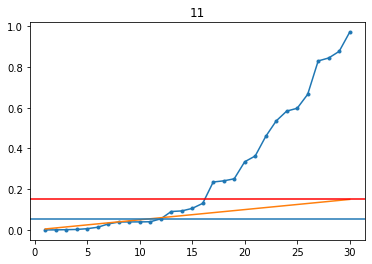

In [ ]:
## Define p index threshold

sortp = np.sort(pvals)
sortp = sortp[np.isfinite(sortp)]
indices = np.arange(1, sortp.size+1, 1)
plt.plot(indices, sortp, marker='.')
alpha_fdr = 0.15
plt.plot(indices, indices/len(indices)*alpha_fdr)

#plt.xlim(0, 5)
#plt.ylim(0, 0.1)
pint = np.where(sortp <= indices/len(indices)*alpha_fdr)[0]
if pint.size==0:
  print('Global null')
  pind = 0
else:
  pind = pint[-1]
#pind = np.argmin(np.abs(indices[1:]/len(indices)*alpha_fdr - sortp[1:]))
plt.axhline(sortp[pind])
plt.axhline(alpha_fdr, color='r')
plt.title(pind)
print(sortp[pind])

Max: 1.2069983892727079, Min: -1.129911391119035


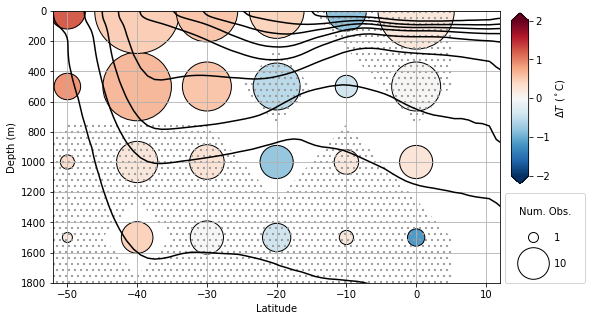

In [ ]:
fig = plt.figure(figsize=(8,5))
countfact = 100
withhatches = True
sc = plt.scatter(latf, depthf, c=temps, vmin=-2, vmax=2, s=counts*countfact, cmap='RdBu_r', edgecolors='k')

print(f'Max: {np.nanmax(temps)}, Min: {np.nanmin(temps)}')


# Make a legend bar
#plt.scatter(-48, 1750, s = 10*100, color='k')
#plt.scatter(-44, 1750, s = 1*100, color='k')
g = lambda s: s/countfact # inverse function to calc. data from size
leg = plt.legend(*sc.legend_elements("sizes", num=[1, 10], func=g, color='w', markeredgecolor='k'), bbox_to_anchor=(1.0, 0.35), handletextpad=1, labelspacing=1.4, borderpad=1.4, title='Num. Obs.')

#mask = ((temps>0) & ((temps - bubble_err[0,:])))
#mask = (np.abs(stds/temps/np.sqrt(counts/1)) > 1) | (counts==1)
#mask = (np.abs(stds/temps/np.sqrt(countstation/1)) > 1) | (counts==1)

#mask = (np.abs(stdstation/temps/np.sqrt(countstation/1)) > 1) | (counts==1)
#mask = (np.abs(stdstation/temps/np.sqrt(dofv+dofg)) > 1) | (counts==1)

#mask = countstation<3
#mask = (np.abs(stds/temps) > 1) | (counts==1)
mask = (pvals>sortp[pind]) | (counts<=1)
#mask = (pvals>alpha_fdr) | (counts<=1)
#mask = (np.sign(bubble_err[0,:])*np.sign(temps) < 1) | (np.sign(bubble_err[1,:])*np.sign(temps)<1)

MASK = mask.reshape(nd, nl)
#plt.scatter(latf[mask], depthf[mask], vmin=-1, vmax=1, s=counts[mask]*100,c='0.0', alpha=0.5)
#plt.contourf(LAT, DEPTH, MASK, 1, hatches=[None,'.'])#, colors='none')
plt.rcParams['hatch.color'] = '0.6'

if withhatches:
  plt.contourf(LATE, DEPTHE, np.vstack((False*MASK[:,0], np.vstack((MASK.T, False*MASK[:,-1])))).T, 1, hatches=[None,'..'], colors='none')
  #LAT, DEPTH = np.meshgrid(lats_bin, depths)
#  plt.contourf(LAT, DEPTH, (MASK), 1, hatches=[None,'..'], colors='none')
plt.ylim(1800, 0)
plt.contour(WOA_TEMPS.lat, WOA_TEMPS.depth, WOA_TEMPS.values, 10,colors='k')
plt.xlim(cutlat-2, 10+2)
plt.grid()
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

#cb = plt.colorbar(extend='both', shrink=0.5, anchor=(1.0,0.5))
cbaxes = fig.add_axes([0.92, 0.4, 0.03, 0.475]) 
cb = plt.colorbar(sc, cax = cbaxes, extend='both') 
cb.set_label('$\Delta T$ ($^\circ$C)')
cb.set_ticks([-2, -1, 0, 1, 2])
#plt.savefig(f'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/Bubbles_3cruise_'+ wodperiod + '_FDR.pdf', bbox_inches='tight')